In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from PrayTimes import prayTimes
import requests
from bs4 import BeautifulSoup

# List of unsolved problems

1. Ignoring abrupt changes in prayer times 
2. Figuring out timezone  ==> Is it always that of where the website is accessed?
3. Accessing correct flight time 

In [2]:
def get_flight_history(flight_number, sel_index = 0):
    url = 'https://www.flightaware.com/live/flight/' + flight_number + '/history'
    hist_link = []
    # Define headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.164 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'DNT': '1',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the link with the specific pattern
        for link in soup.find_all('a'):
            href = link.get('href')
            if href and '/history/2' in href:
                hist_link = hist_link + ['https://www.flightaware.com' + href]
                print('https://www.flightaware.com' + href)


    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
    print(hist_link)
    print('_ selected: ___')
    print(hist_link[sel_index])
    print('_______________')

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) " \
                      "AppleWebKit/537.36 (KHTML, like Gecko) " \
                      "Chrome/114.0.0.0 Safari/537.36"
        }
    url = hist_link[sel_index]+"/tracklog"
    print(url)
    resp = requests.get(url, headers = headers)
    resp.raise_for_status()  # Raise error on bad response

    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find_all('table')
    df = pd.read_html(str(table))
    return df

In [112]:
def Parse24HrTime(time_24hr):
    invalidTime =  '-----'
    if time_24hr == invalidTime:
        return np.nan, np.nan
    if time_24hr[0] == '-':
        hr = 0
        mins = 0
    else:  
        hr = int(time_24hr.split(":")[0])
        mins = int(time_24hr.split(":")[1])

    
    return(hr, mins)

def Extract24HrTime(time_12hr):
    invalidTime =  '-----'
    if time_12hr == invalidTime:
        return np.nan, np.nan
    else:
        exc_day = time_12hr[-2:]
        exc_time = time_12hr[:-3]
        hr = int(exc_time.split(":")[0])
        mins = int(exc_time.split(":")[1])

        if exc_day == 'PM':
            if hr != 12:
                hr += 12
        else:
            if hr == 12:
                hr = 0

        return(hr, mins)

def ConvertTo12Hr(time_24):
    mins = (time_24 - int(time_24))*60
    hrs = int(time_24)
    if hrs > 12:
        day = 'PM'
        hrs -= 12
    elif hrs == 12:
        day = 'PM'
        hrs = hrs
    elif hrs == 0:
        day = 'AM'
        hrs += 12
    else:
        day = 'AM'
    return(hrs, mins, day)

def calculate_inflight_prayertime(diff_time, flight_times):
    diff_indices = np.argwhere(diff_time <= 0.02)
    if len(diff_indices) == 0:
        return np.nan, np.nan
    else:
        prayertime = ConvertTo12Hr(flight_times[diff_indices[0,0]])
        return diff_indices[0], prayertime
    
    

In [114]:
pd_flighthistory = get_flight_history('PIA782', sel_index = 0)

https://www.flightaware.com/live/flight/PIA782/history/20250724/1510Z/CYYZ/OPIS
['https://www.flightaware.com/live/flight/PIA782/history/20250724/1510Z/CYYZ/OPIS']
_ selected: ___
https://www.flightaware.com/live/flight/PIA782/history/20250724/1510Z/CYYZ/OPIS
_______________
https://www.flightaware.com/live/flight/PIA782/history/20250724/1510Z/CYYZ/OPIS/tracklog


In [115]:
df = pd_flighthistory[0]

In [116]:
prayTimes.setMethod('Jafari') #paramaterS: MWL, ISNA, Egypt, Makkah, Karachi, Tehran, Jafari


In [117]:
# cleanup:
unique_facilities = df["Reporting Facility"].unique()
unique_facilities = unique_facilities[1:]
for unique_facility in unique_facilities:
    df = df[~df['LatitudeLat'].str.contains(unique_facility[:5])]
df = df[~df['LatitudeLat'].str.contains("Gap")]

df = df.iloc[5:-5]
# df = df[~df['LatitudeLat'].str.contains('FlightAware')]
# df = df[~df['LatitudeLat'].str.contains('Gander')]
# df = df[~df['LatitudeLat'].str.contains('Surface')]
# df = df[~df['LatitudeLat'].str.contains('Estimated')]
# df = df[~df['LatitudeLat'].str.contains('Montreal')]
# df = df[~df['LatitudeLat'].str.contains('Airline')]

# df = df.iloc[1:]

# df = df.iloc[:-5]

df.to_csv('test.csv')

# Todo: stop before the last row, or remove the last row.


In [118]:
#df = pd_flighthistory[0]
date = (2025, 7, 29)
#CalculationMethod.
format = "%I:%M %p"



NumRecords = len(df)
#print(NumRecords)
longitudes = np.zeros(NumRecords)
latitudes = np.zeros(NumRecords)
fajr_times = np.zeros(NumRecords)
dhuhr_times = np.zeros(NumRecords)
asr_times = np.zeros(NumRecords)
isha_times = np.zeros(NumRecords)
maghrib_times = np.zeros(NumRecords)
sunrise_times = np.zeros(NumRecords)

flight_times = np.zeros(NumRecords)
end_row = df['LatitudeLat'].str.contains('Surface').count()
invalidTime =  '-----'

ind = 0
#for ind_rec in np.arange(1 , NumRecords):
for ind_rec, row in df.iterrows():
    #print(ind_rec)
    height = 35000
    loc_latitude = float(df.LatitudeLat[ind_rec][:6])
    loc_longitude = float(df.LongitudeLon[ind_rec][:6])
    coordinates = (loc_latitude, loc_longitude, height)
    # date = df.date
    #prayer_times = PrayerTimes(coordinates, date, calculation_parameters=params)
    prayer_times = prayTimes.getTimes(date, coordinates, -4)#calculation_parameters=params)

    #prayer_times = PrayerTimes(coordinates, df.date[ind_rec], calculation_parameters=params)
    fajr_time = prayer_times['fajr']#.astimezone(tz).strftime(format)
    dhuhr_time = prayer_times['dhuhr']#.astimezone(tz).strftime(format)
    asr_time = prayer_times['asr']
    maghrib_time = prayer_times['maghrib']#.astimezone(tz).strftime(format)

    isha_time = prayer_times['isha']#.astimezone(tz).strftime(format)
    sunrise_time = prayer_times['sunrise']#.astimezone(tz).strftime(format)
    
    
    
    ext_hr_flight, ext_mins_flight = Extract24HrTime(df['Time (EDT)EDT'][ind_rec][4:])
    
    ext_hr_fajr, ext_mins_fajr = Parse24HrTime(fajr_time)
    ext_hr_dhuhr, ext_mins_dhuhr = Parse24HrTime(dhuhr_time)
    ext_hr_asr, ext_mins_asr = Parse24HrTime(asr_time)

    ext_hr_maghrib, ext_mins_maghrib = Parse24HrTime(maghrib_time)

    ext_hr_isha, ext_mins_isha = Parse24HrTime(isha_time)

    ext_hr_sunrise, ext_mins_sunrise = Parse24HrTime(sunrise_time)

    
    flight_times[ind] = ext_hr_flight + ext_mins_flight/60
    
    fajr_times[ind] = ext_hr_fajr + ext_mins_fajr/60
    sunrise_times[ind] = ext_hr_sunrise + ext_mins_sunrise/60
    dhuhr_times[ind] = ext_hr_dhuhr + ext_mins_dhuhr/60
    asr_times[ind] = ext_hr_asr + ext_mins_asr/60
    maghrib_times[ind] = ext_hr_maghrib + ext_mins_maghrib/60
    isha_times[ind] = ext_hr_isha + ext_mins_isha/60
    longitudes[ind] = loc_longitude
    latitudes[ind] = loc_latitude
    ind +=1
    


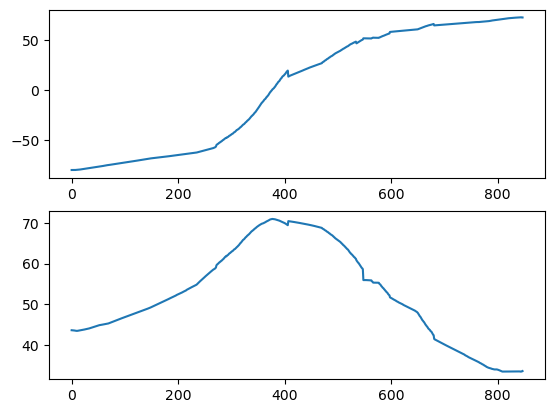

In [119]:
fig, ax = plt.subplots(2)
ax[0].plot(longitudes)
ax[1].plot(latitudes)


Dhuhr Time is at (12, 43.00000000000001, 'PM')
Maghrib Time is at nan
Fajr Time is at nan
Sunrise Time is at nan


/Users/zzaidi/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


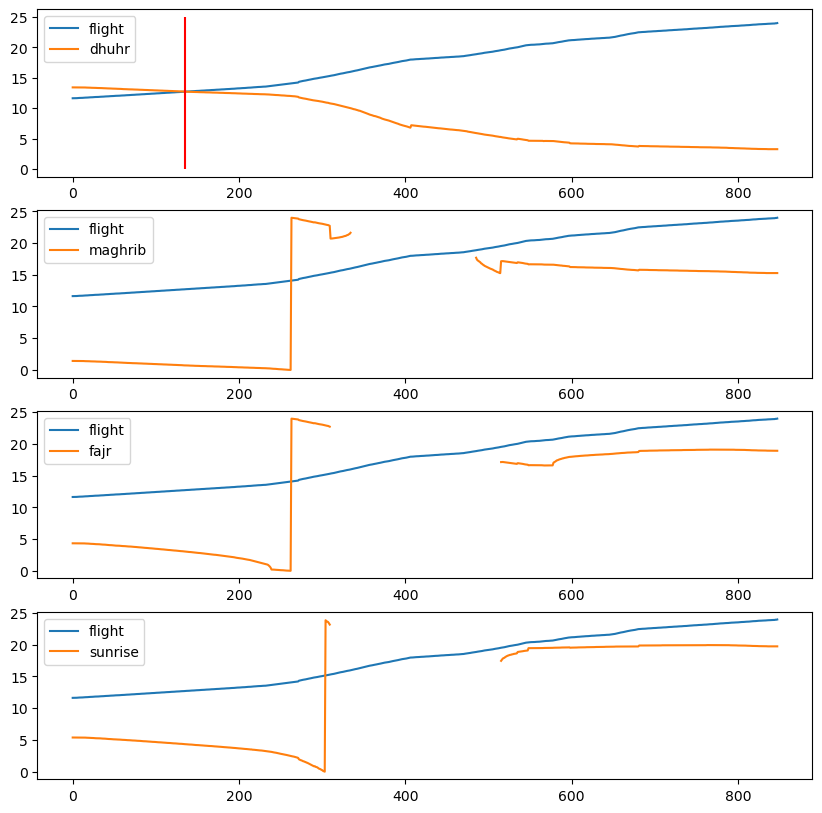

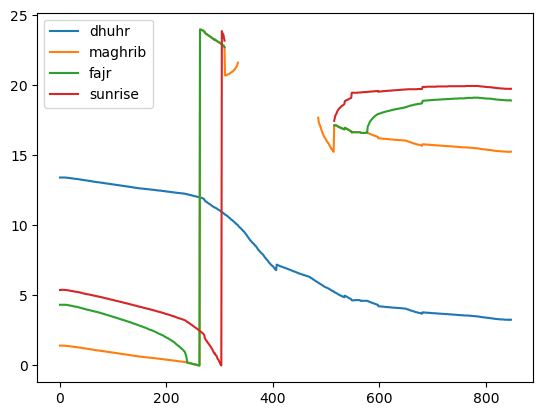

In [120]:
maghrib_times = maghrib_times #+ 20/60 # Shia correction
diff_dhuhr = np.abs(dhuhr_times - flight_times)
diff_maghrib = np.abs(maghrib_times - flight_times)
diff_fajr = np.abs(fajr_times - flight_times)
diff_sunrise = np.abs(sunrise_times - flight_times)

fig, ax = plt.subplots(4, figsize= (10,10) )
ax[0].plot(flight_times)
ax[1].plot(flight_times)
ax[2].plot(flight_times)
ax[3].plot(flight_times)


ax[0].plot(dhuhr_times)
#ax[0].plot(diff_dhuhr)
ax[1].plot(maghrib_times)
#ax[1].plot(diff_maghrib)
ax[2].plot(fajr_times)
#ax[2].plot(diff_fajr)
ax[3].plot(sunrise_times)

ax[0].legend(['flight', 'dhuhr'])#, 'diff_dhuhr'])
ax[1].legend(['flight', 'maghrib'])#, 'diff_maghrib'])
ax[2].legend(['flight', 'fajr'])#, 'diff_fajr'])
ax[3].legend(['flight', 'sunrise'])

# fajr_time_24hr = np.argwhere(diff_fajr == 0)
# dhuhr_time_24hr = np.argwhere(diff_dhuhr == 0)[0]
# maghrib_time_24hr = np.argwhere(diff_maghrib == 0)[0]
# sunrise_time_24hr = np.argwhere(diff_sunrise == 0)[0]

fajr_ind, fajr_time = calculate_inflight_prayertime(diff_fajr, flight_times)
dhuhr_ind, dhuhr_time = calculate_inflight_prayertime(diff_dhuhr, flight_times)
maghrib_ind, maghrib_time = calculate_inflight_prayertime(diff_maghrib, flight_times)
sunrise_ind, sunrise_time = calculate_inflight_prayertime(diff_sunrise, flight_times)

ax[2].vlines(fajr_ind, 0 ,25, color = 'Red')
ax[0].vlines(dhuhr_ind, 0 ,25, color = 'Red')
ax[1].vlines(maghrib_ind, 0 ,25, color = 'Red')
ax[3].vlines(sunrise_ind, 0 ,25, color = 'Red')
            
# print(f'Dhuhr Time is at {ConvertTo12Hr(flight_times[np.argmin(diff_dhuhr)])}')
print(f'Dhuhr Time is at {dhuhr_time}')

# print(f'Maghrib Time is at {ConvertTo12Hr(flight_times[np.argmin(diff_maghrib)])}')
print(f'Maghrib Time is at {maghrib_time}')

print(f'Fajr Time is at {fajr_time}')
print(f'Sunrise Time is at {sunrise_time}')

fig, ax = plt.subplots()
ax.plot(dhuhr_times)
ax.plot(maghrib_times)
ax.plot(fajr_times)
ax.plot(sunrise_times)
ax.legend(['dhuhr', 'maghrib', 'fajr', 'sunrise'])

array([], shape=(0, 1), dtype=int64)

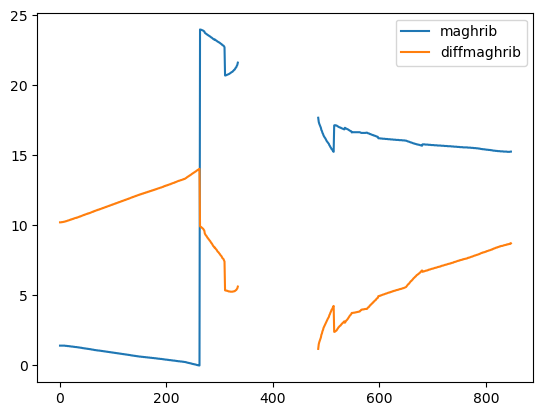

In [121]:
fig, ax = plt.subplots()
ax.plot(maghrib_times, label = 'maghrib')
ax.plot(diff_maghrib, label = 'diffmaghrib')
ax.legend()
np.argwhere(diff_maghrib == 0) 


array([[148],
       [149],
       [726],
       [727]])

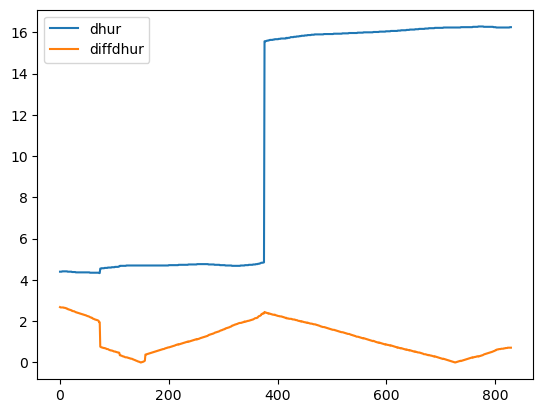

In [47]:
fig, ax = plt.subplots()
ax.plot(dhuhr_times, label = 'dhur')
ax.plot(diff_dhuhr, label = 'diffdhur')
ax.legend()

np.argwhere(diff_dhuhr == 0)

0.0


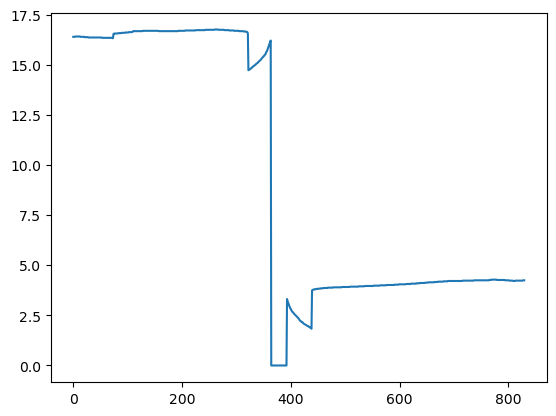

In [53]:
fig, ax = plt.subplots()
ax.plot(maghrib_times)

print(maghrib_times[380])

In [36]:
np.isnan(maghrib_times)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [15]:
bad_maghrib = np.argwhere(maghrib_times == 0.0)

print(bad_maghrib[:,0])

bad_longitude = longitudes[bad_maghrib[0,0]]
bad_latitude = latitudes[bad_maghrib[0,0]]
print([bad_longitude, bad_latitude])



[364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392]
[49.69, 64.135]


In [16]:
bad_coordinates = (bad_latitude, bad_longitude, height)
print(bad_coordinates)
prayer_times = prayTimes.getTimes(date, bad_coordinates, -4)#calculation_parameters=params)
invalidTime =  '-----'

(64.135, 49.69, 35000)


In [17]:
ext_hr_fajr, ext_mins_fajr = Extract24HrTime(prayer_times['fajr'])
fajr_time_temp = ext_hr_fajr + ext_mins_fajr/60
print(fajr_time_temp)

invalid time detected
nan


In [60]:
len(df)

578

In [69]:
np.arange(1,3)

array([1, 2])

In [73]:
df.to_csv('test.csv')

In [30]:
pd_flighthistory[1]

,0
0,Your browser is unsupported. upgrade your browser


# Debug

In [68]:
ind_rec = 3
height = 35000
print(df.LatitudeLat[ind_rec])
print(df.LongitudeLon[ind_rec])
coordinates = (df.LatitudeLat[ind_rec], df.LongitudeLon[ind_rec], height)
print(coordinates)



67.633367.63
-51.0833-51.08
('67.633367.63', '-51.0833-51.08', 35000)


In [75]:
# Need to clean df
int(-71.34*100)/100

-71.34

In [92]:
int(df.LongitudeLon[ind_rec][:6]*100)/100

KeyError: 6

In [94]:
ind_rec = 5
float(df.LongitudeLon[ind_rec][:7])

-50.566

In [97]:
df.LongitudeLon[7]

'-50.2101-50.21'

In [151]:
df.to_csv('test.csv')

In [138]:
df = df[~df['LatitudeLat'].str.contains('FlightAware')]
df = df[~df['LatitudeLat'].str.contains('Gander')]
df = df[~df['LatitudeLat'].str.contains('Surface')]
df = df[~df['LatitudeLat'].str.contains('Estimated')]



578

In [56]:
df

,Time (EDT)EDT,LatitudeLat,LongitudeLon,CourseDir,kts,mph,feet,Rate,Reporting Facility
1,Sat 01:11:46 AM01:11AM,67.433367.43,-51.6333-51.63,↗ 49°,490,564,3.300033e+09,NaN,Gander Center
2,Sat 01:12:46 AM01:12AM,67.533367.53,-51.3833-51.38,↗ 44°,490,564,3.300033e+09,NaN,Gander Center
3,Sat 01:13:46 AM01:13AM,67.633367.63,-51.0833-51.08,↗ 49°,490,564,3.300033e+09,NaN,Gander Center
4,Sat 01:14:46 AM01:14AM,67.716767.72,-50.8333-50.83,↗ 49°,490,564,3.300033e+09,NaN,Gander Center
5,Sat 01:15:47 AM01:15AM,67.816767.82,-50.5667-50.57,↗ 45°,490,564,3.300033e+09,12.0,Gander Center
...,...,...,...,...,...,...,...,...,...
582,Sat 10:19:30 AM10:19AM,31.466931.47,74.403674.40,↑ 1°,157,181,1.900190e+07,-773.0,FlightAware ADS-B (LHE / OPLA)
583,Sat 10:19:46 AM10:19AM,31.479131.48,74.403874.40,↑ 1°,157,181,1.675168e+07,-814.0,FlightAware ADS-B (LHE / OPLA)
584,Sat 10:20:05 AM10:20AM,31.493031.49,74.404074.40,↑ 1°,157,181,1.425142e+07,-814.0,FlightAware ADS-B (LHE / OPLA)
585,Sat 10:20:21 AM10:20AM,31.505331.51,74.404374.40,↑ 1°,156,180,1.200120e+07,-844.0,FlightAware ADS-B (LHE / OPLA)


In [42]:
df['LatitudeLat']

0                                          Gander Center
1                                           67.433367.43
2                                           67.533367.53
3                                           67.633367.63
4                                           67.716767.72
                             ...                        
583                                         31.479131.48
584                                         31.493031.49
585                                         31.505331.51
586                                          FlightAware
587    Sat 10:21:09 AM10:21AM Arrival (LHE) @ Saturda...
Name: LatitudeLat, Length: 588, dtype: object